In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from collections import defaultdict

## Размер выборки
Напишем функцию для оценки размера выборки. Проверим на искусственных данных, что она работает корректно.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

In [ ]:
def get_sample_size(std, eff, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta = stats.norm.ppf(1 - beta)
    disp_sum = 2 * (std ** 2)
    sample_size = int(
        np.ceil(
            (t_alpha + t_beta) ** 2 * disp_sum / eff ** 2
        )
    )
    return sample_size


def plot_pvalue_distribution_power(dict_pvalues, alpha=0.05):
    """Рисует графики распределения pvalue."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues <= x) for x in X]
        prob_p = np.mean(np.array(pvalues) < alpha)
        plt.plot(X, Y, label=f'{key}, prob_p={prob_p:0.2f}')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

Проверим что функция оценки размера групп работает правильно

sample_size = 1570



  0%|          | 0/5000 [00:00<?, ?it/s]

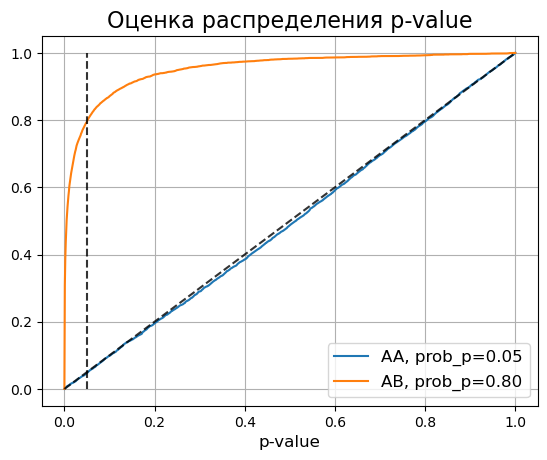

In [3]:
mu = 10
std = 1
eff = 0.1
alpha = 0.05
beta = 0.2

sample_size = get_sample_size(std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

dict_pvalues = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.normal(mu, std, (2, sample_size))
    b = np.random.normal(mu + eff, std, sample_size)
    dict_pvalues['AA'].append(stats.ttest_ind(a_one, a_two).pvalue)
    dict_pvalues['AB'].append(stats.ttest_ind(a_one, b).pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=alpha)

### Разные дисперсии и размеры групп

sample_size = 1570



  0%|          | 0/5000 [00:00<?, ?it/s]

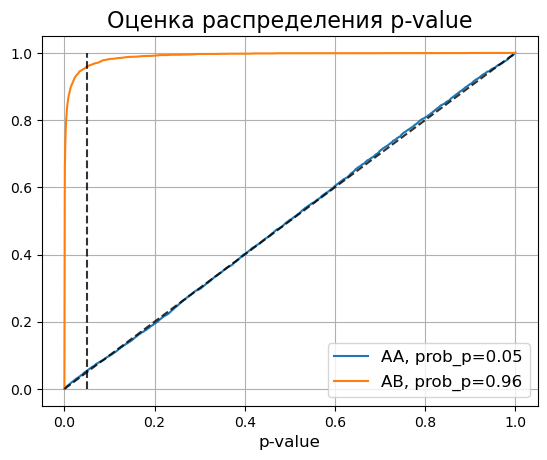

In [4]:
mu = 10
std = 1
eff = 0.1
alpha = 0.05
beta = 0.2

sample_size = get_sample_size(std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

dict_pvalues = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one = np.random.normal(mu, std, sample_size * 2)
    a_two = np.random.normal(mu, std, sample_size)
    b = np.random.normal(mu + eff, std * 0.8, sample_size)
    dict_pvalues['AA'].append(stats.ttest_ind(a_one, a_two, equal_var=False).pvalue)
    dict_pvalues['AB'].append(stats.ttest_ind(a_one, b, equal_var=False).pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=alpha)

## Цена ошибки
mu и std мы можем оценить по историческим данным, alpha и beta - определяем сами допустимые для нас ошибки. Как определить ожидаемый эффект, к чему могут привести завышенные ожидания?

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадаю, посмотрим как будет меняться ошибка второго рода.

sample_size = 252



  0%|          | 0/9 [00:00<?, ?it/s]

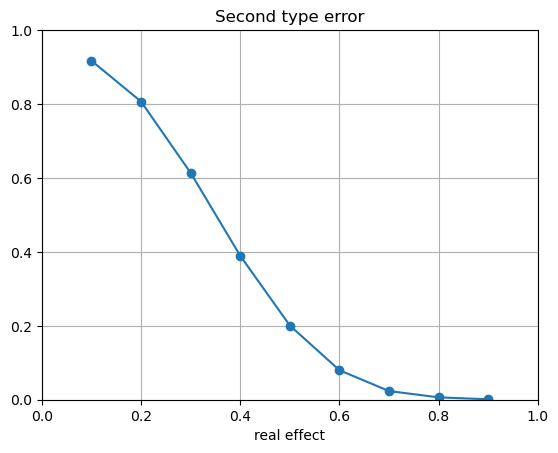

In [5]:
mu = 10
std = 2
eff = 0.5
alpha = 0.05
beta = 0.2

real_effs = np.linspace(0.1, 0.9, 9)


sample_size = get_sample_size(std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

second_errors = []
for real_eff in tqdm(real_effs):
    result_ab = []
    for _ in range(5000):
        a, b = np.random.normal(mu, std, (2, sample_size))
        b += real_eff
        pvalue = stats.ttest_ind(a, b).pvalue
        result_ab.append(int(pvalue < alpha))
    second_errors.append(1 - np.mean(result_ab))

plt.plot(real_effs, second_errors, '-o')
plt.title('Second type error')
plt.xlabel('real effect')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

Получаем, что если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данных с запасом.

## Различные сценарии
Cколько нужно данных, чтобы отлавливать различные эффекты с различными ошибками первого и второго рода.

In [6]:
def get_table_sample_size(mu, std, effects, errors):
    results = []
    for eff in effects:
        results_eff = []
        for err in errors:
            results_eff.append(
                get_sample_size(
                    std,
                    eff=eff,
                    alpha=err,
                    beta=err
                )
            )
        results.append(results_eff)
        
    df_results = pd.DataFrame(results)
    df_results.index = pd.MultiIndex(
        levels=[effects],
        codes=[np.arange(len(effects))],
        names=['effects']
    )
    df_results.columns = pd.MultiIndex.from_tuples(
        [(err, ) for err in errors],
        names=['errors']
    )
    return df_results

In [7]:
effects = np.linspace(0.1, 1, 10)
errors = [0.05, 0.1, 0.15, 0.2]

get_table_sample_size(10, 2, effects, errors)

errors,0.05,0.10,0.15,0.20
effects,,,,
0.1,10396,6852,4905,3607
0.2,2599,1713,1227,902
0.3,1156,762,545,401
0.4,650,429,307,226
0.5,416,275,197,145
0.6,289,191,137,101
0.7,213,140,101,74
0.8,163,108,77,57
0.9,129,85,61,45


## MDE

MDE (minimal detectable effect) - минимальный эффект который могли поймать.

$$\varepsilon^2 > \frac{\left[ \Phi^{-1} \left( 1- \alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{n}$$

In [8]:
def get_mde(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta = stats.norm.ppf(1 - beta)
    disp_sum = 2 * (std ** 2)
    mde = (t_alpha + t_beta) * disp_sum ** 0.5 / sample_size ** 0.5
    return mde

Проверим что работает

eff = 0.35724509894626044


  0%|          | 0/5000 [00:00<?, ?it/s]

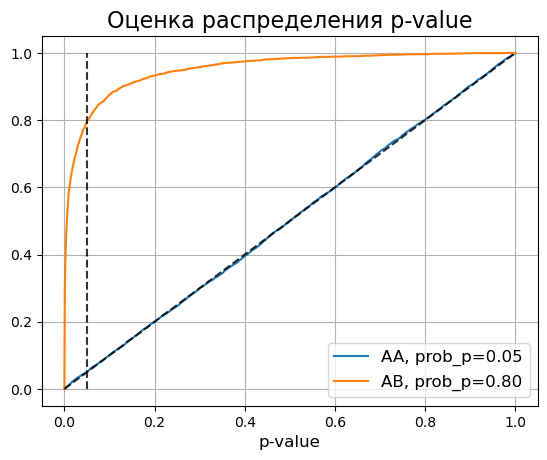

In [9]:
mu = 10
std = 1
# eff = 0.1
alpha = 0.05
beta = 0.2
sample_size = 123

eff = get_mde(std, sample_size, alpha, beta)
print(f'eff = {eff}')

dict_pvalues = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.normal(mu, std, (2, sample_size))
    b = np.random.normal(mu + eff, std, sample_size)
    dict_pvalues['AA'].append(stats.ttest_ind(a_one, a_two).pvalue)
    dict_pvalues['AB'].append(stats.ttest_ind(a_one, b).pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=alpha)

## Оценим MDE и Sample Size для прошлого эксперимента

### Гипотеза о равенстве средних

1. Какой mde если сплитить весь трафик за день на две группы?
2. Какой нужен размер групп чтобы быть способным обнаружить эффект в 10 мс?

In [10]:
df = pd.read_csv('../data/02-backend.csv')
df.head()

,day,group,load_time
0,0,-,79.0
1,0,-,51.6
2,0,-,70.1
3,0,-,68.6
4,0,-,60.3


In [11]:
df.groupby(['day', 'group'])[['load_time']].agg(['count', 'mean', 'max', 'min'])

load_time                        
              count       mean    max   min
day group                                  
0   -         10867  70.226889  724.7   0.0
1   -         10691  70.586568  696.7   0.0
2   -         10414  70.146399  727.7   0.0
3   -         10283  70.418098  730.3   0.0
4   -         10987  70.293647  659.2   0.0
5   -          9432  70.516974  721.2   0.0
6   -          9278  70.037045  692.4   0.0
7   a          4449  71.051922  680.5   0.0
    b          4600  73.627326  702.7  44.3

In [12]:
alpha = 0.01
beta = 0.05
df_before = df[df['day'] <= 6].copy()
std = df_before['load_time'].std()
eff = 10

get_sample_size(std, eff, alpha, beta)

158

In [13]:
alpha = 0.01
beta = 0.05
df_before = df[df['day'] <= 6].copy()
std = df_before['load_time'].std()
sample_size = int(len(df_before) / 7 / 2)

get_mde(std, sample_size, alpha, beta)

1.7511250002553937

### Гипотеза о равенстве 99% квантилей

1. Какой mde если сплитить весь трафик за день на две группы?
2. Какой нужен размер групп чтобы быть способным обнаружить эффект в 10 мс?

In [14]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

def print_bernoulli_ci(dict_res):
    for name, values in dict_res.items():
        std_ = (np.var(values) / len(values)) ** 0.5
        pe = np.mean(values)
        left, right = pe - 1.96 * std_, pe + 1.96 * std_
        print(f'{name}: pe={pe:0.3f}, [{left:0.3f}, {right:0.3f}]')

In [15]:
B = 1000
n_iter = 350
effect = 3
q = 0.99
dict_res = defaultdict(list)
for day in range(7):
    values = df[df['day'] == day]['load_time'].values
    values = values[values > 0]
    len_ = len(values)
    masks = np.random.binomial(1, 0.5, (n_iter // 7, len_)) == 1
    for mask in tqdm(masks):
        a = values[mask]
        b = values[~mask]
        pe = np.quantile(b, q) - np.quantile(a, q)
        bootstrap_stats = (
            np.quantile(np.random.choice(b, (B, len(b))), q, axis=1)
            - np.quantile(np.random.choice(a, (B, len(a))), q, axis=1)
        )
        ci = get_normal_ci(bootstrap_stats, pe, alpha)
        res = 1 - int(ci[0] < 0 < ci[1])
        dict_res['AA'].append(res)
        ci = get_normal_ci(bootstrap_stats + effect, pe + effect, alpha)
        res = 1 - int(ci[0] < 0 < ci[1])
        dict_res['AB'].append(res)
print_bernoulli_ci(dict_res)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

AA: pe=0.009, [-0.001, 0.018]
AB: pe=0.523, [0.471, 0.575]


In [16]:
B = 1000
n_iter = 350
effect = 10
sample_size = 1000
q = 0.99
dict_res = defaultdict(list)
for day in tqdm(range(7)):
    values = df[df['day'] == day]['load_time'].values
    values = values[values > 0]
    for _ in range(n_iter // 7):
        a, b = np.random.choice(values, (2, sample_size), False)
        pe = np.quantile(b, q) - np.quantile(a, q)
        bootstrap_stats = (
            np.quantile(np.random.choice(b, (B, len(b))), q, axis=1)
            - np.quantile(np.random.choice(a, (B, len(a))), q, axis=1)
        )
        ci = get_normal_ci(bootstrap_stats, pe, alpha)
        res = 1 - int(ci[0] < 0 < ci[1])
        dict_res['AA'].append(res)
        ci = get_normal_ci(bootstrap_stats + effect, pe + effect, alpha)
        res = 1 - int(ci[0] < 0 < ci[1])
        dict_res['AB'].append(res)
print_bernoulli_ci(dict_res)

  0%|          | 0/7 [00:00<?, ?it/s]

AA: pe=0.003, [-0.003, 0.008]
AB: pe=0.726, [0.679, 0.772]
